In [1]:
# import required packages

import pandas as pd 
import numpy as np
import os, gc, time, warnings

from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
from scipy.sparse import csr_matrix, hstack, vstack

import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
import pydot, graphviz
from IPython.display import Image

import string, re, nltk, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
# settings

os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
ps = PorterStemmer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [3]:
# print the names of files available in the root directory
print(os.listdir('../input'))

['nslkdd-dataset', 'fasttext']


In [4]:
# import the dataset

train = pd.read_csv('../input/nslkdd-dataset/KDDTrain.csv')
test = pd.read_csv('../input/nslkdd-dataset/KDDTest.csv')

In [5]:
print("Training data information...")
train.info()

Training data information...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_

In [6]:
print('Test data information...')
test.info()

Test data information...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
duration                       22544 non-null int64
protocol_type                  22544 non-null object
service                        22544 non-null object
flag                           22544 non-null object
src_bytes                      22544 non-null int64
dst_bytes                      22544 non-null int64
land                           22544 non-null int64
wrong_fragment                 22544 non-null int64
urgent                         22544 non-null int64
hot                            22544 non-null int64
num_failed_logins              22544 non-null int64
logged_in                      22544 non-null int64
num_compromised                22544 non-null int64
root_shell                     22544 non-null int64
su_attempted                   22544 non-null int64
num_root                       22544 non-null int64
num_file_creations             

<div>
    <h3> Feature Engineering </h3>
    <p> We will extract useful features from the existing ones, and convert some features into formats suitable for training on different categories of models. </p>
</div>

In [7]:
# obtaining a new target variable for each attack class

attack_classes = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 
                  'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep',
                  'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']

train_label = pd.DataFrame()
test_label = pd.DataFrame()

for attack_type in attack_classes:
    train_label[attack_type] = train['attack_class'].apply(lambda x : int(x == attack_type))
    test_label[attack_type] = test['attack_class'].apply(lambda x : int(x == attack_type))

In [8]:
# extracting numerical labels from categorical data

encoder = LabelEncoder()

train['protocol_type_label'] = encoder.fit_transform(train['protocol_type'])
test['protocol_type_label'] = encoder.fit_transform(test['protocol_type'])

train['service_label'] = encoder.fit_transform(train['service'])
test['service_label'] = encoder.fit_transform(test['service'])

train['flag_label'] = encoder.fit_transform(train['flag'])
test['flag_label'] = encoder.fit_transform(test['flag'])

In [9]:
# removing useless columns

train.drop(['attack_class', 'num_learners'], axis = 1, inplace = True)
test.drop(['attack_class', 'num_learners'], axis = 1, inplace = True)

In [10]:
print("Training data information...")
train.info()

Training data information...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 44 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_

In [11]:
# creating dataframes for storing training data for stacked model

stacked_train_df = {}
stacked_test_df = {}

for attack_type in attack_classes:
    stacked_train_df[attack_type] = pd.DataFrame()
    stacked_test_df[attack_type] = pd.DataFrame()

In [12]:
# preparing data for training on models

x_train = train.copy(deep = True)
x_train.drop(['protocol_type', 'service', 'flag'], axis = 1, inplace = True)

x_test = test.copy(deep = True)
x_test.drop(['protocol_type', 'service', 'flag'], axis = 1, inplace = True)

<div>
    <h3>Linear Models</h3>
</div>

In [13]:
# logistic regression classifier

def getLRClf():
    clf = LogisticRegression(C = 0.2, solver = 'liblinear')
    return clf

In [14]:
# training on logistic regression classifier

lr_accuracy = []

for attack_type in attack_classes:
    clf = getLRClf()
    clf.fit(x_train, train_label[attack_type])
    y_pred = clf.predict(x_test)
    stacked_train_df[attack_type]['logistic_regression'] = clf.predict(x_train)
    stacked_test_df[attack_type]['logistic_regression'] = y_pred
    lr_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_lr_accuracy = np.mean(lr_accuracy)
    
print("Logistic Regression Classifier...")
print("Mean Accuracy score : " + str(mean_lr_accuracy))

Logistic Regression Classifier...
Mean Accuracy score : 0.9754239053290956


In [15]:
# SGD classifier

def getSGDClf():
    clf = SGDClassifier(max_iter = 1000, tol = 1e-3, learning_rate = 'optimal')
    return clf

In [16]:
# training on SGD classifier

sgd_accuracy = []

for attack_type in attack_classes:
    clf = getSGDClf()
    clf.fit(x_train, train_label[attack_type])
    y_pred = clf.predict(x_test)
    stacked_train_df[attack_type]['sgd'] = clf.predict(x_train)
    stacked_test_df[attack_type]['sgd'] = y_pred
    sgd_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_sgd_accuracy = np.mean(sgd_accuracy)
    
print("SGD Classifier...")
print("Mean Accuracy score : " + str(mean_sgd_accuracy))

SGD Classifier...
Mean Accuracy score : 0.9301134785694447


<div><h3>Gradient Boosting Decision Tree (GBDT) Ensemble Models</h3></div>

In [17]:
# lgbm classifier

import lightgbm as lgb

def getlgbclf(d_train, valid_sets):
    params = {'learning_rate': 0.2, 'application': 'binary', 'num_leaves': 31, 'verbosity': -1,
          'bagging_fraction': 0.8, 'feature_fraction': 0.6, 'nthread': 4, 'lambda_l1': 1, 'lambda_l2': 1}
    
    clf = lgb.train(params, train_set = d_train, num_boost_round = 300, early_stopping_rounds = 100,
                    valid_sets = valid_sets, verbose_eval = False)   
    
    return clf

In [18]:
# training on lgbm classifier

lgb_accuracy = []

for attack_type in attack_classes:
    d_train = lgb.Dataset(x_train, label = train_label[attack_type])
    d_test = lgb.Dataset(x_test, label = test_label[attack_type])
    valid_sets = [d_train, d_test]
    clf = getlgbclf(d_train, valid_sets)
    y_pred = (clf.predict(x_test) >= 0.5).astype(int)
    stacked_train_df[attack_type]['lgbm'] = (clf.predict(x_train) >= 0.5).astype(int)
    stacked_test_df[attack_type]['lgbm'] = y_pred
    lgb_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_lgb_accuracy = np.mean(lgb_accuracy)
    
print("LGBM Classifier...")
print("Mean Accuracy score : " + str(mean_lgb_accuracy))

LGBM Classifier...
Mean Accuracy score : 0.9838017249359706


In [19]:
# XGBoost classifier

import xgboost as xgb

def getxgbclf(d_train, eval_list):
    params = {'booster' : 'gbtree', 'nthread' : 4, 'eta' : 0.2, 'max_depth' : 6, 'min_child_weight' : 4,
          'subsample' : 0.7, 'colsample_bytree' : 0.7, 'objective' : 'binary:logistic'}

    clf = xgb.train(params, d_train, num_boost_round = 300, early_stopping_rounds = 100, 
                    evals = evallist, verbose_eval = False)
    return clf

In [20]:
# training on XGBoost classifier

xgb_accuracy = []

for attack_type in attack_classes:
    d_train = xgb.DMatrix(x_train, label = train_label[attack_type])
    d_test = xgb.DMatrix(x_test, label = test_label[attack_type])
    evallist = [(d_train, 'train'), (d_test, 'valid')]
    clf = getxgbclf(d_train, evallist)
    y_pred = (clf.predict(d_test) >= 0.5).astype(int)
    stacked_train_df[attack_type]['xgb'] = (clf.predict(d_train) >= 0.5).astype(int)
    stacked_test_df[attack_type]['xgb'] = y_pred
    xgb_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_xgb_accuracy = np.mean(xgb_accuracy)
    
print("XGBoost Classifier...")
print("Mean Accuracy score : " + str(mean_xgb_accuracy))

XGBoost Classifier...
Mean Accuracy score : 0.9849125960440646


<div><h3>Deep Learning Model</h3></div>

In [21]:
# Deep Neural Network classifier

def getdnnclf():
    clf = Sequential()
    clf.add(Dense(1024, input_dim = 41, activation = 'relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(1024, activation = 'relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(512, activation = 'relu'))
    clf.add(Dense(64, activation = 'relu'))
    clf.add(Dense(1, activation = 'sigmoid'))
    clf.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return clf

In [22]:
# training on DNN classifier

dnn_accuracy = []

for attack_type in attack_classes:
    clf = getdnnclf()
    clf.fit(x_train, train_label[attack_type], batch_size = 1024, epochs = 5, 
            validation_data = (x_test, test_label[attack_type]), verbose = 0)
    y_pred = (clf.predict(x_test) >= 0.5).astype(int)
    stacked_train_df[attack_type]['dnn'] = (clf.predict(x_train) >= 0.5).astype(int)
    stacked_test_df[attack_type]['dnn'] = y_pred
    dnn_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_dnn_accuracy = np.mean(dnn_accuracy)
    
print("Deep Neural Network Classifier...")
print("Mean Accuracy score : " + str(mean_dnn_accuracy))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Deep Neural Network Classifier...
Mean Accuracy score : 0.9630808930169409


<div><h3>Stacked Model</h3>
    <p> Stacked Model contains all the models we have trained above as base learners. We will use a Logistic Regression classifier to combine the outputs of all the base learners to give a single output with greater accuracy.
    </p>
</div>

In [23]:
# training on stacked classifier

stacked_accuracy = []

for attack_type in attack_classes:
    clf = getLRClf()
    clf.fit(stacked_train_df[attack_type], train_label[attack_type])
    y_pred = clf.predict(stacked_test_df[attack_type])
    stacked_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_stacked_accuracy = np.mean(stacked_accuracy)
    
print("Stacked Classifier...")
print("Mean Accuracy score : " + str(mean_stacked_accuracy))

Stacked Classifier...
Mean Accuracy score : 0.9848933100873268


<div><h3>Comparing Performances of all the models trained</h3></div>

In [24]:
# models comparison

columns = ['Average Accuracy Score']
rows = ['Log Reg', 'SGD', 'LGBM', 'XGBoost', 'DNN', 'Stacked Model']
scores = [[mean_lr_accuracy], [mean_sgd_accuracy], [mean_lgb_accuracy], [mean_xgb_accuracy], 
          [mean_dnn_accuracy], [mean_stacked_accuracy]]

table = pd.DataFrame(data = scores, columns = columns, index = rows)
print(table)

               Average Accuracy Score
Log Reg                      0.975424
SGD                          0.930113
LGBM                         0.983802
XGBoost                      0.984913
DNN                          0.963081
Stacked Model                0.984893


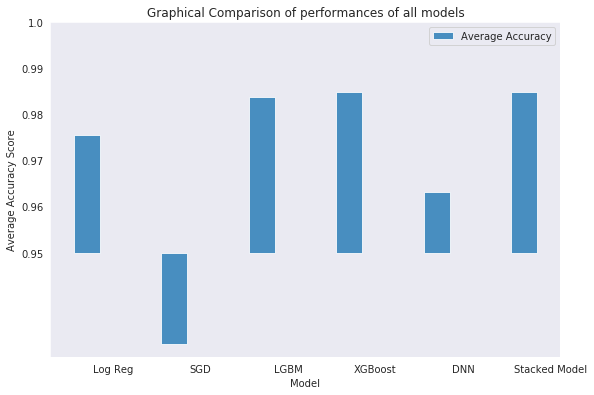

In [25]:
# graphical comparison

n_groups = 6
acc = [item[0]-0.95 for item in scores]

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.8
 
rects = plt.bar(index, acc, bar_width, alpha = opacity, align = 'center', label = 'Average Accuracy')

plt.xlabel('Model')
plt.ylabel('Average Accuracy Score')
plt.title('Graphical Comparison of performances of all models')
plt.xticks(index + bar_width, rows)
plt.yticks([0.00, 0.01, 0.02, 0.03, 0.04, 0.05], [0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
plt.legend()

fig = plt.tight_layout(rect = (0, 0, 1.4, 1.4))
plt.show()